    Exploring seasonal pattern in ARIMA model.
    
    The seasonal autoregressive integrated moving average (SARIMA) model adds seasonal parameters to the ARIMA(p,d,q) model
    
    SARIMA(p,d,q)(P,D,Q)m model
        where 
        P is the order of the seasonal AR(P) process, 
        D is the seasonal order of integration, 
        Q is the order of the seasonal MA(Q) process, and 
        m is the frequency,
        
     SARIMA(p,d,q)(0,0,0)m model is equivalent to an ARIMA(p,d,q) model.

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Visualizing
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.shape

(144, 2)

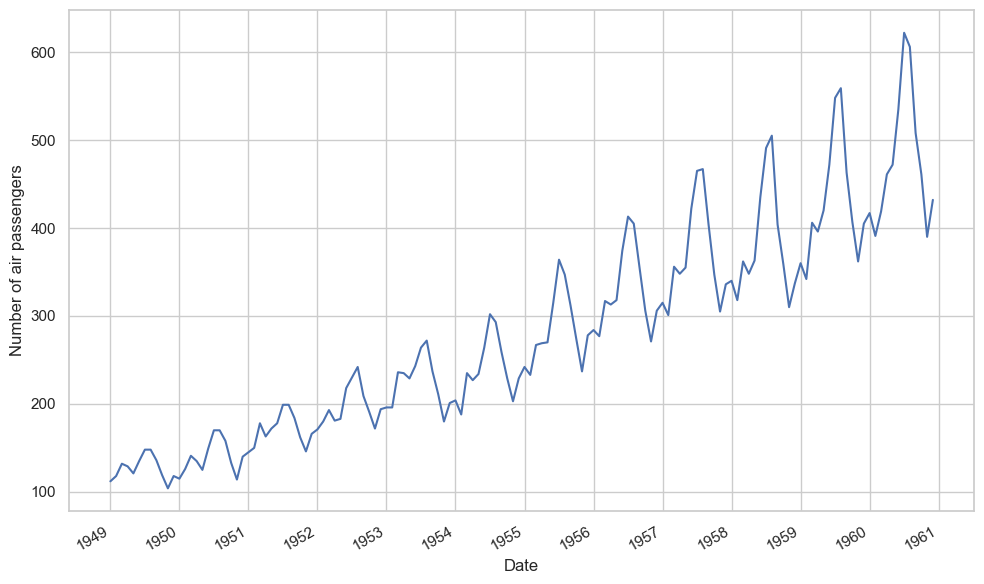

In [4]:
# Grid style
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 'Passengers' data against 'Month' using Seaborn's lineplot
sns.lineplot(data=df, x='Month', y='Passengers', ax=ax)

# Set labels for the x and y axes
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

# Customize the x-axis tick positions and labels
ax.set_xticks(np.arange(0, 145, 12))
ax.set_xticklabels(np.arange(1949, 1962, 1))

# Automatically format 
fig.autofmt_xdate()

plt.tight_layout()

# Show the plot
plt.show()

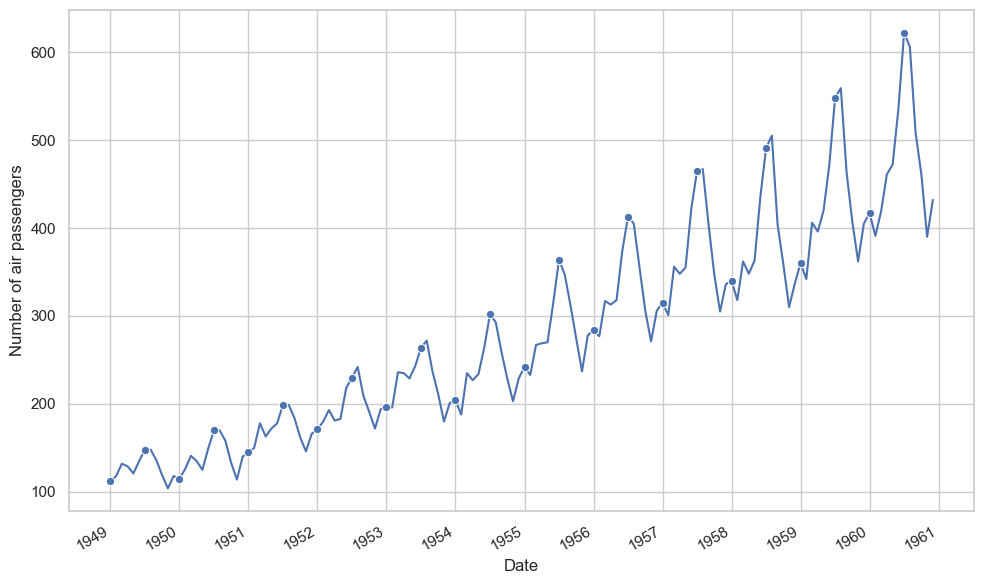

In [5]:
# Grid style
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 'Passengers' data against 'Month' using Seaborn's lineplot
sns.lineplot(data=df, x='Month', y='Passengers', ax=ax, marker='o', markevery=6)

# Set labels for the x and y axes
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

# Customize the x-axis tick positions and labels
ax.set_xticks(np.arange(0, 145, 12))
ax.set_xticklabels(np.arange(1949, 1962, 1))

# Automatically format 
fig.autofmt_xdate()

plt.tight_layout()

# Show the plot
plt.show()

In [6]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
test

,Month,Passengers,naive_seasonal
132,1960-01,417,360
133,1960-02,391,342
134,1960-03,419,406
135,1960-04,461,396
136,1960-05,472,420
137,1960-06,535,472
138,1960-07,622,548
139,1960-08,606,559
140,1960-09,508,463
141,1960-10,461,407


# Forecasting with an ARIMA(p,d,q) model

In [7]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060543
p-value: 0.9918802434376411


    Inference :
        Series is not stationary. (p_value >> 0.05)
        
    we use differencing method.

In [8]:
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241700034
p-value: 0.054213290283824954


    Inference :
        Series is not stationary in first order differencing. 
        (p_value >> 0.05)
    
    we use second order differencing method.

In [9]:
df_diff2 = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.384231542468488
p-value: 2.7328918500143186e-29


    Inference :
        Series is stationary in Second order differencing. 
        (p_value >> 0.05)

    This means -> d=2

    Now what are the parameters p and q, that fit all unique ARIMA(p,d,q) model.

In [10]:
from typing import Union
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [11]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    warnings.filterwarnings('ignore')
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [12]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2 # 2nd order differenced to make stationary
D = 0 # working with ARIMA Model
s = 12 # s is equivalent to m.

ARIMA_order_list = list(product(ps, qs))

train = df['Passengers'][:-12]

ARIMA_result_df = optimize_ARIMA(train, ARIMA_order_list, d)
ARIMA_result_df[:1]

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(11, 3)",1016.882539


In [13]:
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  132
Model:              SARIMAX(11, 2, 3)   Log Likelihood                -493.441
Date:                Sat, 16 Sep 2023   AIC                           1016.883
Time:                        01:29:32   BIC                           1059.896
Sample:                             0   HQIC                          1034.360
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8246      0.100     -8.230      0.000      -1.021      -0.628
ar.L2         -0.9617      0.049    -19.562      0.000      -1.058      -0.865
ar.L3         -0.8508      0.087     -9.727      0.0

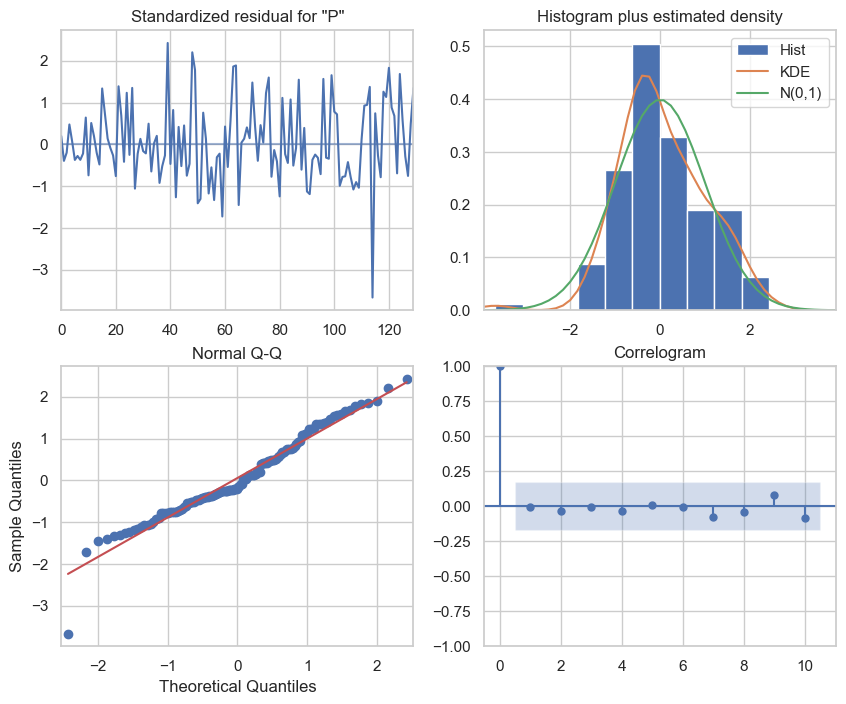

In [14]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

    Inference : 
        No trend and Constant variance in Residual.
    
        Close to Normal Distribution
    
        Q-Q plot : data is normally distributed

        No significant autocorrelation coefficients after lag 0.

    So we test the residual. (Ljung-Box test)

    The Ljung-Box test is a statistical test used to assess whether the residuals (errors) from a time series model exhibit autocorrelation at various lags.

    Ho : Residual are Independent and Uncorrelated
        Fail to reject Ho. (p_value > 0.05)

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = ARIMA_model_fit.resid

acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,6.553342,0.010469
2,6.662852,0.035742
3,6.921491,0.074443
4,7.746347,0.101324
5,8.382048,0.136399
6,8.695782,0.191424
7,9.561079,0.214841
8,9.788074,0.280217
9,9.797564,0.367121
10,11.574797,0.314521


In [16]:
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,Month,Passengers,naive_seasonal,ARIMA_pred
132,1960-01,417,360,422.219410
133,1960-02,391,342,410.550579
134,1960-03,419,406,461.609056
135,1960-04,461,396,457.396312
136,1960-05,472,420,481.462237
137,1960-06,535,472,530.756316
138,1960-07,622,548,606.038649
139,1960-08,606,559,615.341865
140,1960-09,508,463,525.654874
141,1960-10,461,407,467.442132


# Forecasting with a SARIMA(p,d,q)(P,D,Q)m model

In [17]:
ad_fuller_result = adfuller(df['Passengers'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060543
p-value: 0.9918802434376411


    Inference :
        Series is not stationary. (p_value >> 0.05)
    
    we use differencing method.

In [18]:
df_diff = np.diff(df['Passengers'], n=1)
ad_fuller_result = adfuller(df_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241700034
p-value: 0.054213290283824954


    Inference :
        Series is not stationary in first order differencing. 
        (p_value >> 0.05)

    we use second order differencing method.

In [19]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)
ad_fuller_result = adfuller(df_diff_seasonal_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.624862360200556
p-value: 3.8230468558474035e-30


    Inference :
            Series is stationary in Second order differencing. 
            (p_value >> 0.05)

    This means -> d = 1 we performed one round of differencing.
    one round of seasonal differencing, meaning that D = 1.

In [20]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    warnings.filterwarnings('ignore')
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [21]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df[:1]

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.251091


    After optimization we find :
        SARIMA(2,1,1)(1,1,2) model, because AIC has lowest value.

In [22]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -439.126
Date:                                 Sat, 16 Sep 2023   AIC                            892.251
Time:                                         01:37:31   BIC                            911.705
Sample:                                              0   HQIC                           900.151
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2629      0.085    -14.845      0.000      -1.430      -1

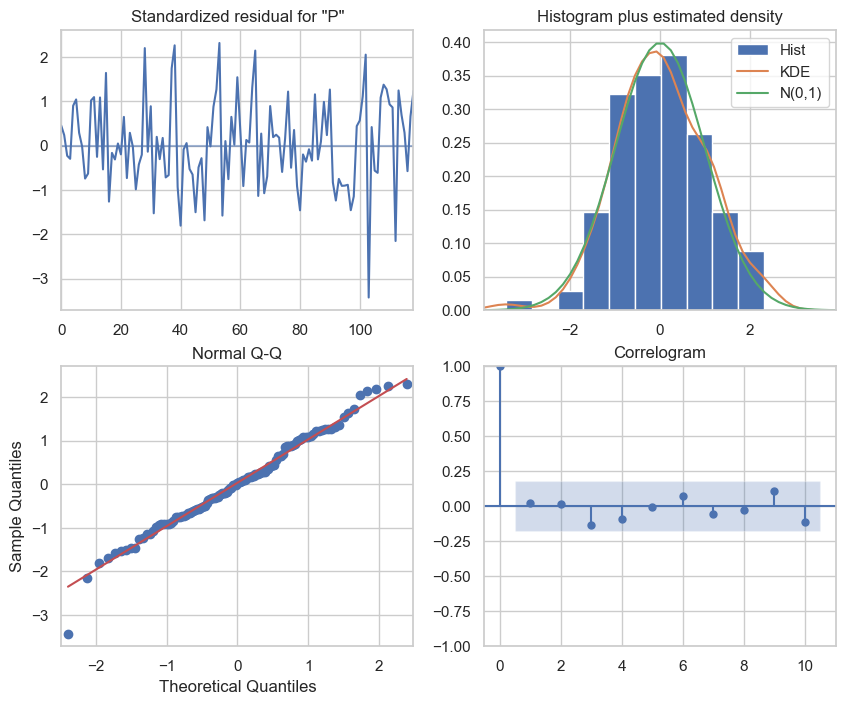

In [23]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

    Inference : 
        No trend and Constant variance in Residual.
    
        Close to Normal Distribution
    
        Q-Q plot : data is normally distributed

        No significant autocorrelation coefficients after lag 0.

    So we test the residual. (Ljung-Box test)

    The Ljung-Box test is a statistical test used to assess whether the residuals (errors) from a time series model exhibit autocorrelation at various lags.
    
    Ho : Residual are Independent and Uncorrelated
        Fail to reject Ho. (p_value > 0.05)

In [24]:
residuals = SARIMA_model_fit.resid

acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.003203,0.954867
2,0.754275,0.685822
3,1.030191,0.793947
4,1.237118,0.871950
5,1.446700,0.919137
6,1.719122,0.943636
7,2.313297,0.940488
8,2.732054,0.950032
9,2.748702,0.973431
10,4.994229,0.891563


    From Ljung-Box test : 
        All p_value >> 0.05
        Hence -> are independent and uncorrelated, just like white noise.

In [25]:
# Using SARIMA model prediction
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

# Add to column SARIMA_pred in test DataFrame
test['SARIMA_pred'] = SARIMA_pred
test

,Month,Passengers,naive_seasonal,ARIMA_pred,SARIMA_pred
132,1960-01,417,360,422.219410,418.554981
133,1960-02,391,342,410.550579,399.588156
134,1960-03,419,406,461.609056,461.318102
135,1960-04,461,396,457.396312,451.438234
136,1960-05,472,420,481.462237,473.727089
137,1960-06,535,472,530.756316,538.749925
138,1960-07,622,548,606.038649,612.384922
139,1960-08,606,559,615.341865,624.554514
140,1960-09,508,463,525.654874,520.143852
141,1960-10,461,407,467.442132,462.840584


# Comparing the performance of each forecasting method

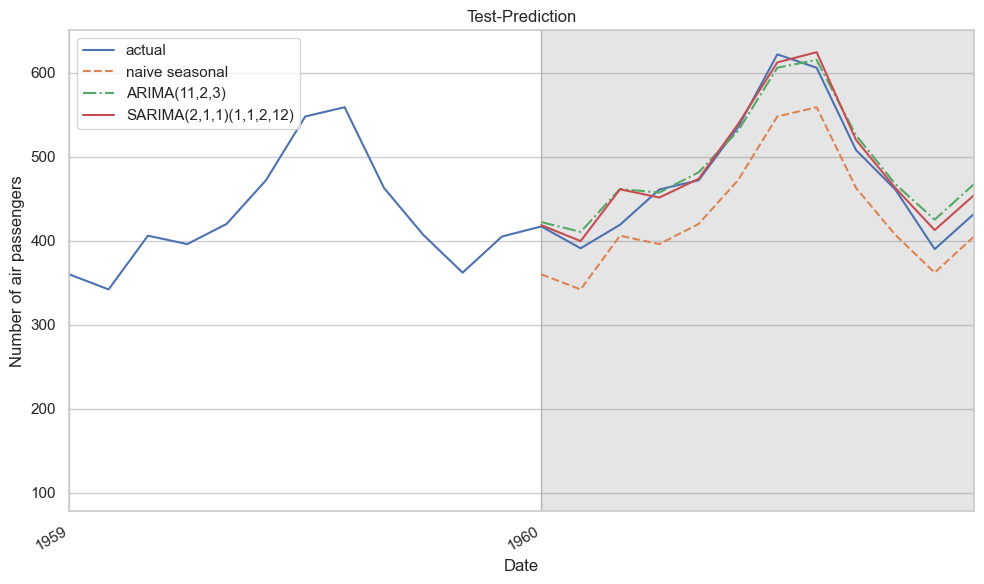

In [26]:
# Grid style
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

plt.title('Test-Prediction')

# Plot the 'Passengers' data against 'Month' using Seaborn's lineplot
sns.lineplot(data=df, x='Month', y='Passengers', ax=ax, label='actual')

# Plot other lines with different line styles and labels
sns.lineplot(data=test, x=test.index, y='naive_seasonal', ax=ax, label='naive seasonal', linestyle='--')
sns.lineplot(data=test, x=test.index, y='ARIMA_pred', ax=ax, label='ARIMA(11,2,3)', linestyle='-.')
sns.lineplot(data=test, x=test.index, y='SARIMA_pred', ax=ax, label='SARIMA(2,1,1)(1,1,2,12)', linestyle='-')

# Set labels for the x and y axes
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

# Add a shaded region
ax.axvspan(132, 143, color='#808080', alpha=0.2)

# Set the legend in the upper left corner
ax.legend(loc=2)

# Customize the x-axis tick positions and labels
ax.set_xticks(np.arange(0, 145, 12))
ax.set_xticklabels(np.arange(1949, 1962, 1))

# Set the x-axis limits
ax.set_xlim(120, 143)

# Automatically format the x-axis date 
fig.autofmt_xdate()

plt.tight_layout()

# Show the plot
plt.show()

In [27]:
# Function to calucate Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
# Compute the MAPE for each forecasting method.
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])

mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])

mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

9.987532920823485 3.8494699577520755 2.8484370484038224


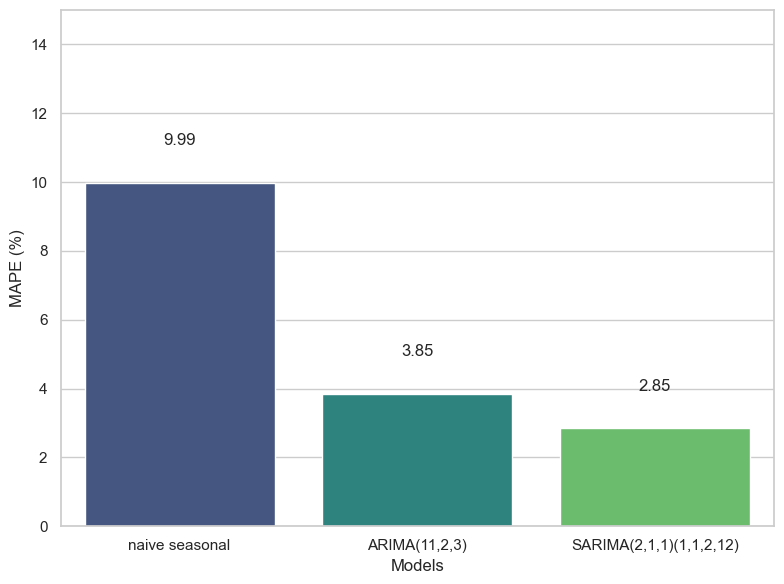

In [29]:
# Grid style
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Define the data for x (model names) and y (MAPE values)
x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

# Create a bar plot using Seaborn's barplot
sns.barplot(x=x, y=y, ax=ax, palette="viridis")

# Set labels for the x and y axes
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')

# Set the y-axis limit
ax.set_ylim(0, 15)

# Add data labels above the bars
for index, value in enumerate(y):
    ax.text(index, value + 1, str(round(value, 2)), ha='center', va='bottom', fontsize=12)

plt.tight_layout()

plt.show()

    Best-Performing Model -> SARIMA Model (lowest MAPE value)